# Chip Game

game description

open questions
- what arrangements are the closes to "fair"?
- closed form characterization of odds
- equivalence between reduced form and original game

In [1]:
%matplotlib notebook

import numpy as np
from scipy.special import factorial
import sympy as sym

import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d


import os
import re

import ipywidgets as widgets
from ipywidgets import interact

In [2]:
# https://dandrake.livejournal.com/83095.html
def compositions(n,k):
  if n < 0 or k < 0:
    return
  elif k == 0:
    # the empty sum, by convention, is zero, so only return something if
    # n is zero
    if n == 0:
      yield []
    return
  elif k == 1:
    yield [n]
    return
  else:
    for i in range(0,n+1):
      for comp in compositions(n-i,k-1):
        yield [i] + comp
        
# https://stackoverflow.com/questions/1806278/convert-fraction-to-float        
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        if type(frac_str) == bytes:
            frac_str = frac_str.decode()
        try:
            num, denom = frac_str.split('/')
        except ValueError:
            return None
        try:
            leading, num = num.split(' ')
        except ValueError:
            return float(num) / float(denom)        
        if float(leading) < 0:
            sign_mult = -1
        else:
            sign_mult = 1
        return float(leading) + sign_mult * (float(num) / float(denom))
    
# https://stackoverflow.com/questions/10035752/elegant-python-code-for-integer-partitioning
def partitions(n, I=1):
    yield (n,)
    for i in range(I, n//2 + 1):
        for p in partitions(n-i, i):
            yield (i,) + p

In [3]:
def make_reduced_game(spaces, A, D):
    defender_parts = list(partitions(D))
    defender_parts = [p for p in defender_parts if len(p) <= spaces]
   
    attacker_parts = list(partitions(A))
    attacker_parts = [p for p in attacker_parts if len(p) <= spaces]
    

    M = np.zeros((len(defender_parts), len(attacker_parts)))

    for d in range(len(defender_parts)):
        for a in range(len(attacker_parts)): 
            bins = np.array(list(defender_parts[d]))
            bins.sort()
            bins = bins[::-1]
            ways = 1 # number of ways to arrange the partitions into the bins
            attack_chips = list(attacker_parts[a])
            attack_chips.sort(reverse=True)

            for i,p in enumerate(attack_chips):
                    if np.all(p > bins):
                        ways = 0
                        break
                    ways *= np.sum(bins >= p) - i
            unique, counts = np.unique(attack_chips, return_counts=True)
            # divide by redundant counts
            redundancies = np.array(list(map(factorial,counts)), dtype=int).prod()
            ways = ways // redundancies

            attack_chips = np.pad(attack_chips, (0,spaces - len(attack_chips)), mode='constant')
            unique, counts = np.unique(attack_chips, return_counts=True)
            redundancies = np.array(list(map(factorial,counts)), dtype=int).prod()
            ratio = ways / (factorial(spaces) / redundancies)
            M[d,a] = ratio
            #print(factorial(spaces) / redundancies)
            #print(bins, attack_chips, ways, ratio)

    return M

def write_reduced_game(spaces, A, D, M):
    directory = "gamesN"
    filename = "reduced_chipGame_n{}_A{}_D{}.nfg".format(spaces, A, D)
    # array sorcery, https://stackoverflow.com/questions/5347065/interweaving-two-numpy-arrays
    a = M.T.flatten()
    b = -M.T.flatten()
    c = np.empty((a.size + b.size,), dtype=a.dtype)
    c[0::2] = a
    c[1::2] = b
    zerosum_form = c
    with open(os.path.join(directory,filename),'w') as file:
        file.writelines('NFG 1 R "Chip Game"\n') 
        file.writelines(r'{ "Defender" "Attacker" } ' + '{{ {} {} }}\n'.format(*np.shape(M)))
        np.savetxt(file, zerosum_form, fmt='%f')   
    return M

In [4]:
def make_nfg_file(spaces, A, D):
    defender = np.array([c for c in compositions(D,spaces)])
    attacker = np.array([c for c in compositions(A, spaces)])

    M = np.zeros((len(defender),len(attacker)), dtype=int)
    for i in range(len(defender)):
        for j in range(len(attacker)):
            M[i,j] = 1 if not np.any((defender[i,:] - attacker[j,:]) < 0) else 0
            #print(i,j,M[i,j],defender[i,:], attacker[j,:])


    directory = "gamesN"
    filename = "chipGame_n{}_A{}_D{}.nfg".format(spaces, A, D)
    # array sorcery, https://stackoverflow.com/questions/5347065/interweaving-two-numpy-arrays
    a = M.T.flatten()
    b = -M.T.flatten()
    c = np.empty((a.size + b.size,), dtype=a.dtype)
    c[0::2] = a
    c[1::2] = b
    zerosum_form = c
    with open(os.path.join(directory,filename),'w') as file:
        file.writelines('NFG 1 R "Chip Game"\n') 
        file.writelines(r'{ "Defender" "Attacker" } ' + '{{ {} {} }}\n'.format(len(defender),len(attacker)))
        np.savetxt(file, zerosum_form, fmt='%i')   
    return M

def get_results(spaces, A, D, reduced=False):
    game = 'chipGame_n{}_A{}_D{}'.format(spaces,A,D)
    if reduced:
        game = 'reduced_chipGame_n{}_A{}_D{}'.format(spaces,A,D)

    filename = game + '.nfg'
    directory = 'gamesN'
    normalFormMatrix = np.loadtxt(os.path.join(directory, filename), skiprows=2)
    with open(os.path.join(directory, filename), 'r') as file:
        file.readline()
        header = file.readline()
        pattern = re.compile(r'{.*?} { (\d*) (\d*) }.*?')
        nums = pattern.findall(header)[0]
        defender_strategies, attacker_strategies = map(int, nums)

   
    M = normalFormMatrix[::2].reshape((defender_strategies, attacker_strategies), order="F")

    filename = game + '.out'
    converters = {i:convert_to_float for i in range(defender_strategies+attacker_strategies+1)}
    equilibrium = np.genfromtxt(os.path.join(directory, filename), delimiter=',', 
                                usecols=range(1,1+defender_strategies+attacker_strategies),
                                converters =  converters)

    defenderStrat = equilibrium[0:defender_strategies]
    attackerStrat = equilibrium[defender_strategies:]

    expected_value = defenderStrat@M@attackerStrat
    
    return attackerStrat, defenderStrat, expected_value, M
    

In [5]:
# create nfg files
spaces = 7
max_spaces = 7
max_attack = 10
max_defense = 10
for A in range(1,max_attack):
    for D in range(1,max_defense):
        #make_nfg_file(spaces, A, D)
        
        M = make_reduced_game(spaces, A, D)
        write_reduced_game(spaces, A, D, M)

In [6]:
defender_wins = np.zeros((max_spaces+1, max_defense, max_attack))

for spaces in range(1,max_spaces+1):
    for A in range(1,max_attack):
        for D in range(1,max_defense):
            
            attackerStrat, defenderStrat, expected_value, M = get_results(spaces, A, D, True)
            defender_wins[spaces,A-1,D-1] = expected_value

<IPython.core.display.Javascript object>


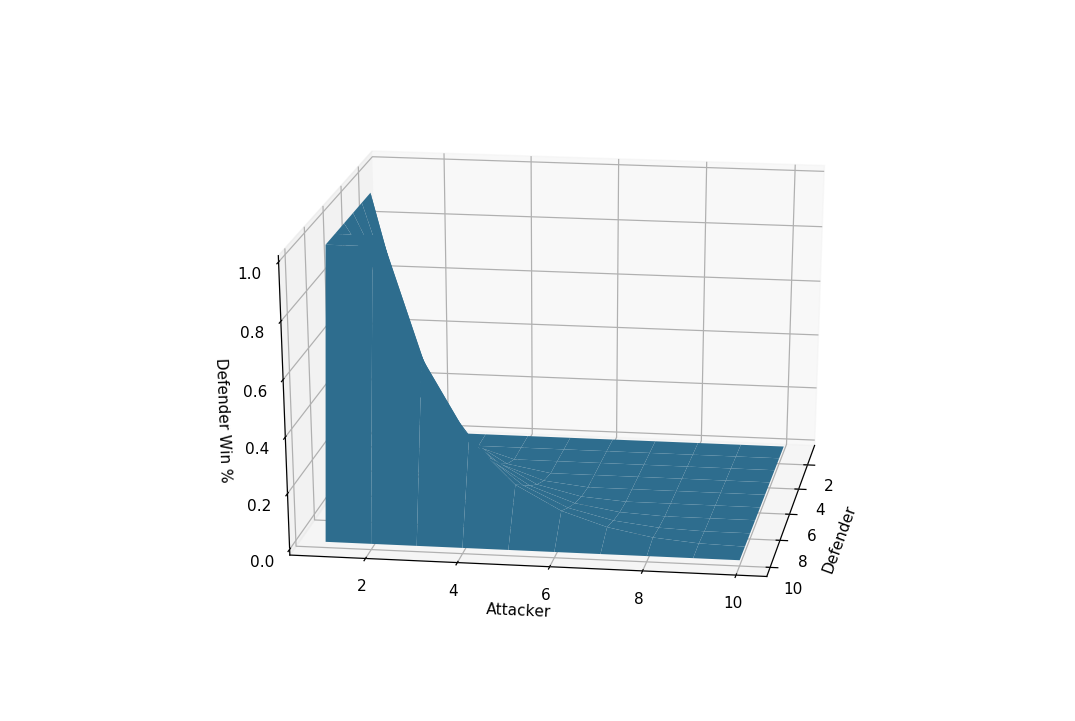

interactive(children=(IntSlider(value=4, description='x', max=7, min=1), Output()), _dom_classes=('widget-inte…

<function __main__.focus(x)>

In [11]:
fig = plt.figure()
ax = fig.gca(projection='3d')
X = np.arange(1, max_defense+1)
Y = np.arange(1, max_attack+1)
X, Y = np.meshgrid(X, Y)
ax.set_zlabel("Defender Win %")
ax.set_ylabel("Attacker")
ax.set_xlabel("Defender")

surfs = [None]*max_spaces

for spaces in range(1,max_spaces):
    surfs[spaces] = ax.plot_surface(X, Y, defender_wins[spaces,:,:], color=plt.cm.viridis.colors[spaces*40])
    surfs[spaces].set_facecolor((*plt.cm.viridis.colors[spaces*40],0.05*spaces))


def focus(x):
    for i in range(1,max_spaces):
        #print(i, 1-np.abs((i-x)/spaces))
        #surfs[i].set_facecolor((*plt.cm.viridis.colors[i*40],(1-np.abs((i-x)/(spaces+1)))**10))
        surfs[i].set_facecolor((*plt.cm.viridis.colors[i*20+10],x==i))
        #surfs[i].set_facecolor((*plt.cm.viridis.colors[spaces*40],
         #                      1 - 2*(np.abs(x-i))))
    
interact(focus, x=(1,spaces+1))   

In [8]:
fig, ax = plt.subplots(1,1)
x = np.arange(0, defender_wins.shape[1])
ax.plot(x,x)

<IPython.core.display.Javascript object>

In [9]:
defender_wins[2,:,:]

array([[0.5       , 1.        , 1.        , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.        ],
       [0.        , 0.33333333, 0.5       , 1.        , 1.        ,
        1.        , 1.        , 1.        , 1.        , 0.        ],
       [0.        , 0.        , 0.25      , 0.5       , 0.5       ,
        1.        , 1.        , 1.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 0.2       , 0.33333333,
        0.5       , 0.5       , 1.        , 1.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.16666667,
        0.33333333, 0.5       , 0.5       , 0.5       , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.14285714, 0.25      , 0.33333333, 0.5       , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.125     , 0.25      , 0.33333333, 0.        ],
       [0.        , 0.        , 0.       

In [10]:
for i in range(max_attack):
    for j in range(max_defense):
        a,d,e,M = get_results(spaces, i, j, False)
        a,d,e_reduced,M = get_results(spaces, i, j, False)
        print(e - e_reduced)

OSError: gamesN\chipGame_n6_A0_D0.nfg not found.

In [ ]:
n[::2].reshape(len(d), len(a), order='F')

In [ ]:
a

In [ ]:
M

In [ ]:
x = make_nfg_file(3,2,4)

In [ ]:
np.shape(x)

In [ ]:
converters = {i:convert_to_float for i in range(15+6+1)}
equilibrium = np.genfromtxt(os.path.join(directory, 'test.out'), delimiter=',', 
                                usecols=range(1,1+15+6),
                                converters =  converters)
defenderStrat = equilibrium[:,0:15]
attackerStrat = equilibrium[:,15:]


In [ ]:
for i in range(len(defenderStrat)):
    print(i, defenderStrat[i,:]@M@attackerStrat[i,:])

In [ ]:
print(defenderStrat[10,:])
print(attackerStrat[10,:])
print(M)

In [ ]:
np.vstack((M.T.flatten(),-M.T.flatten())).reshape((-1,),order='A')

In [ ]:
a = M.T.flatten()
b = -M.T.flatten()
c = np.empty((a.size + b.size,), dtype=a.dtype)
c[0::2] = a
c[1::2] = b
print(c)

In [ ]:
c

In [ ]:
M

In [ ]:
# https://stackoverflow.com/questions/10035752/elegant-python-code-for-integer-partitioning
def partitions(n, I=1):
    yield (n,)
    for i in range(I, n//2 + 1):
        for p in partitions(n-i, i):
            yield (i,) + p

In [ ]:
defender_parts
d = np.zeros((len(defender_parts), spaces))

In [ ]:
d[0] = defender_parts[0]

In [ ]:
d